Przygotowanie danych historycznych.
Główne funkcjonalności: \
1) czytywanie danych giełdowych z wielu plików CSV. \
2) Dodawanie informacji o tickerze (symbolu akcji). \
3) Filtrowanie danych na podstawie liczby rekordów i zakresu dat. \


In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from datetime import datetime
import os
from pyspark.sql.functions import to_date
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
input_dir = '/content/drive/My Drive/HSBC'

In [3]:
spark = SparkSession.builder \
    .appName("Stocks Data Analysis") \
    .getOrCreate()

In [4]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [5]:
# Schemat dla plików CSV
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Close", DoubleType(), True)
])

In [7]:
def process_file(file_path, n_steps):
    df = spark.read.csv(file_path, schema=schema, header=False)

    df = df.withColumn("Symbol", F.input_file_name()) \
        .withColumn("Symbol", F.element_at(F.split(F.col("Symbol"), "\\."), 1))

    df = df.withColumn('count', F.count("Symbol").over(Window.partitionBy('Symbol')))

    df = df.withColumn("Date", F.to_date(F.to_timestamp(F.col('Date'), 'yy-MM-dd')))
    df = df.filter(F.col("Date") >= datetime(2019, 1, 2)) \
           .filter(F.col('Date') <= datetime(2024, 12, 30))

    # Funkcja do obliczania zwrotu (rolling window)
    window = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(1 - n_steps, 0)
    df = df.withColumn("return", \
                       (F.col("Close") - F.first("Close").over(window)) / F.first("Close").over(window))

    return df.orderBy("Symbol", "Date")

Liczba kroków jest równa 100 i jest to okno dwudziestu tygodni (giełda nie jest otwarta w weekedy). Obliczanie zwrotu z inwestycji dla każdego symbolu akcji w oknie czasowym o długości n_steps, a wynik jest dodawany do final_df. Teraz dane mogą być przetwarzane dalej lub eksportowane. Exportujemy dane do PandasDataFrame

In [8]:
# Obliczany jest zwrot z inwestycji (return) jako procentowa zmiana wartości w oknie czasowym o długości n_steps dni.
# Używane są okna czasowe (Window), które grupują dane według Symbol i sortują według daty.
n_steps = 100

all_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]

dataframes = {}
for file_path in all_files:
    # Klucz w słowniku to nazwa pliku bez rozszerzenia
    file_name = os.path.basename(file_path).split('.')[0]
    dataframes[file_name] = process_file(file_path, n_steps)

# Przykład dostępu do poszczególnych DataFrame'ów
for symbol, df in dataframes.items():
    print(f"Symbol: {symbol}")
    df.show(5)

Symbol: S&P_500_historical_data
+----------+-----------------+--------------------+-----+--------------------+
|      Date|            Close|              Symbol|count|              return|
+----------+-----------------+--------------------+-----+--------------------+
|2019-01-02|  2476.9599609375|file:///content/d...| 1512|                 0.0|
|2019-01-03|   2491.919921875|file:///content/d...| 1512|0.006039645845481423|
|2019-01-04|   2474.330078125|file:///content/d...| 1512|-0.00106173812010...|
|2019-01-07|2535.610107421875|file:///content/d...| 1512|0.023678277973527118|
|2019-01-08|2568.110107421875|file:///content/d...| 1512| 0.03679920060148076|
+----------+-----------------+--------------------+-----+--------------------+
only showing top 5 rows

Symbol: Dow_Jones_historical_data
+----------+---------------+--------------------+-----+--------------------+
|      Date|          Close|              Symbol|count|              return|
+----------+---------------+----------------

In [9]:
symbol = "S&P_500_historical_data"
for symbol in dataframes:
    final_df = dataframes[symbol]

    pandas_df = final_df.toPandas()

    pandas_df = pandas_df.assign(stock_returns=pandas_df['Close'])

    print(pandas_df.head())

         Date        Close                                             Symbol  \
0  2019-01-02  2476.959961  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
1  2019-01-03  2491.919922  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
2  2019-01-04  2474.330078  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
3  2019-01-07  2535.610107  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
4  2019-01-08  2568.110107  file:///content/drive/My%20Drive/HSBC/S&P_500_...   

   count    return  stock_returns  
0   1512  0.000000    2476.959961  
1   1512  0.006040    2491.919922  
2   1512 -0.001062    2474.330078  
3   1512  0.023678    2535.610107  
4   1512  0.036799    2568.110107  
         Date         Close  \
0  2019-01-02  23058.609375   
1  2019-01-03  23176.390625   
2  2019-01-04  22894.919922   
3  2019-01-07  23474.259766   
4  2019-01-08  23680.320312   

                                              Symbol  count    return  \
0  file:///content/drive/My%20Drive/H

VaR calculated directly from historical returns

In [16]:
def historical_var(returns, alpha=0.01):
    return np.percentile(returns, 100 * alpha)

for symbol in dataframes:
    final_df = dataframes[symbol]
    var_historical = historical_var(final_df.toPandas()['return'])
    print(var_historical)

-0.1739988791015994
-0.19418574875496994
-0.24648615473926788
-0.15411615596075348


Assumes returns are normally distributed. Calculating VaR using the mean and standard deviation of the returns.

In [17]:
def parametric_var(returns, alpha=0.01):
    mean = np.mean(returns)
    std_dev = np.std(returns)
    z_score = abs(np.percentile(np.random.standard_normal(100000), 100 * alpha))
    return mean - z_score * std_dev

for symbol in dataframes:
    final_df = dataframes[symbol]
    var_parametric = parametric_var(final_df.toPandas()['return'])
    print(var_parametric)

-0.15600878001390683
-0.1575387827325207
-0.21012688710211347
-0.18086000379593545


Simulating many potential outcomes for the portfolio using historical data, then calculating the percentile of simulated losses.

In [18]:
from typing_extensions import final
def monte_carlo_var(returns, alpha=0.01, n_simulations=100000):
    mean = np.mean(returns)
    std_dev = np.std(returns)
    simulated_returns = np.random.normal(mean, std_dev, n_simulations)
    return np.percentile(simulated_returns, 100 * alpha)
for symbol in dataframes:
    final_df = dataframes[symbol]
    var_monte_carlo = monte_carlo_var(final_df.toPandas()['return'])
    print(var_monte_carlo)


-0.15520040194522564
-0.1572930377851396
-0.21082925139297934
-0.1813666525308446


Different lookback periods

In [57]:
def historical_var_periods(dataframes, lookback_periods, alpha=0.01):
    var_results = {}

    for symbol, final_df in dataframes.items():
        data = final_df.toPandas()

        data['return'] = data['Close'].pct_change()
        data.dropna(subset=['return'], inplace=True)

        var_results[symbol] = {}

        for period in lookback_periods:

            rolling_returns = data['return'].rolling(period)
            var_series = rolling_returns.apply(lambda x: np.percentile(x, 100 * alpha), raw=True)
            var_series.dropna(inplace=True)
            var_results[symbol][period] = var_series

    return var_results

In [74]:
lookback_periods = [30, 50, 100, 250]
var_results = historical_var_periods(dataframes, lookback_periods=lookback_periods, alpha=0.01)
for symbol, period_results in var_results.items():
    for period, series in period_results.items():
        print(f"Symbol: {symbol}, Lookback: {period} days")
        print(series.head())

Symbol: S&P_500_historical_data, Lookback: 30 days
30   -0.008623
31   -0.008623
32   -0.008434
33   -0.008434
34   -0.008434
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 50 days
50   -0.011127
51   -0.011127
52   -0.011127
53   -0.011127
54   -0.011127
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 100 days
100   -0.012960
101   -0.014086
102   -0.014086
103   -0.014086
104   -0.014086
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 250 days
250   -0.016816
251   -0.016816
252   -0.016816
253   -0.016816
254   -0.016816
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 30 days
30   -0.011188
31   -0.011188
32   -0.007488
33   -0.007488
34   -0.007488
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 50 days
50   -0.011889
51   -0.011889
52   -0.011426
53   -0.011426
54   -0.011426
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 100 days


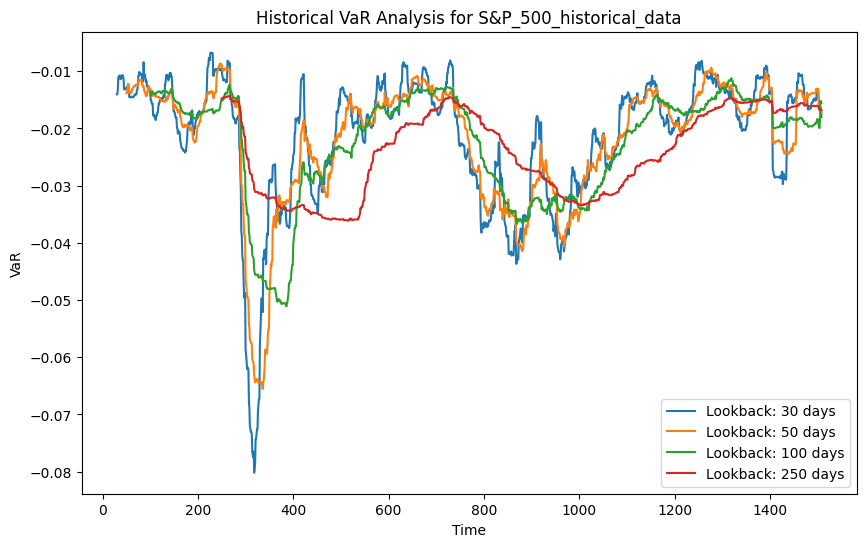

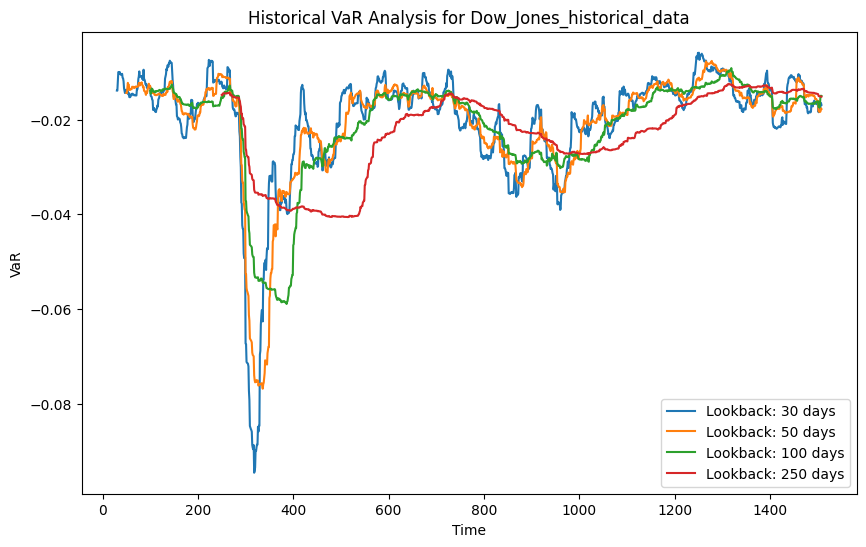

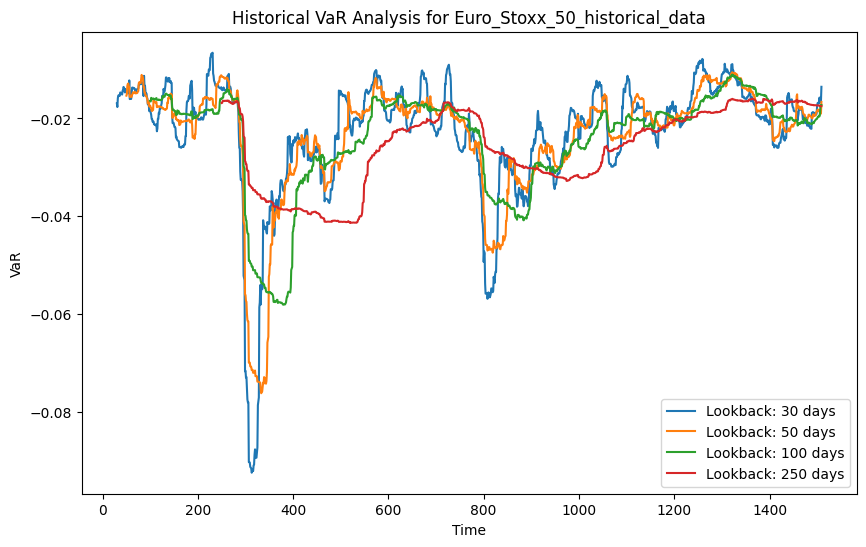

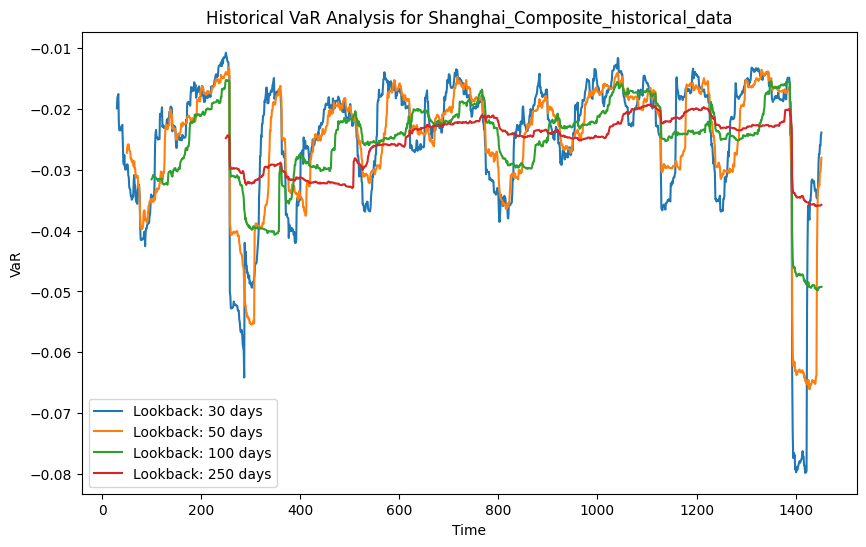

In [81]:
for symbol, period_results in var_results.items():
    plt.figure(figsize=(10, 6))
    for period, series in period_results.items():
        plt.plot(series.index, series.values, label=f'Lookback: {period} days')
    plt.title(f'Historical VaR Analysis for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('VaR')
    plt.legend()
    plt.show()

In [71]:
def parametric_var_periods(dataframes, lookback_periods, alpha=0.01):
    var_results = {}

    # Loop through each symbol and its corresponding DataFrame
    for symbol, final_df in dataframes.items():
        data = final_df.toPandas()

        data['return'] = data['Close'].pct_change()
        data.dropna(subset=['return'], inplace=True)

        var_results[symbol] = {}

        for period in lookback_periods:
            rolling_mean = data['return'].rolling(period).mean()
            rolling_std = data['return'].rolling(period).std()

            z_score = abs(np.percentile(np.random.standard_normal(100000), 100 * alpha))
            var_series = rolling_mean - z_score * rolling_std

            var_series.dropna(inplace=True)

            var_results[symbol][period] = var_series

    return var_results


In [75]:
lookback_periods = [30, 50, 100, 250]
var_results2 = parametric_var_periods(dataframes, lookback_periods=lookback_periods, alpha=0.01)
for symbol, period_results in var_results2.items():
    for period, series in period_results.items():
        print(f"Symbol: {symbol}, Lookback: {period} days")
        print(series.head())

Symbol: S&P_500_historical_data, Lookback: 30 days
30   -0.014161
31   -0.014161
32   -0.013203
33   -0.011195
34   -0.010987
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 50 days
50   -0.013985
51   -0.013989
52   -0.013448
53   -0.012346
54   -0.012385
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 100 days
100   -0.013789
101   -0.014367
102   -0.014198
103   -0.013626
104   -0.013603
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 250 days
250   -0.014863
251   -0.014953
252   -0.014888
253   -0.014654
254   -0.014628
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 30 days
30   -0.014042
31   -0.014062
32   -0.012200
33   -0.010108
34   -0.010123
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 50 days
50   -0.014645
51   -0.014659
52   -0.013637
53   -0.012467
54   -0.012888
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 100 days


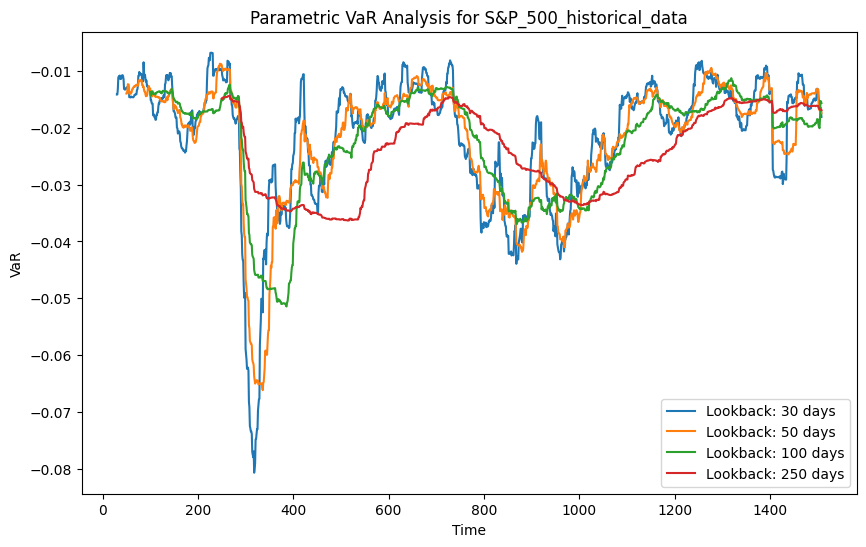

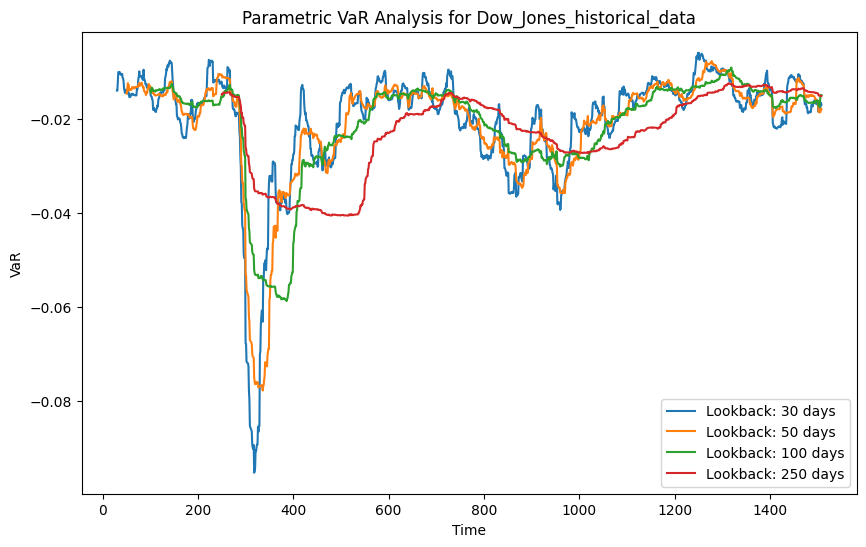

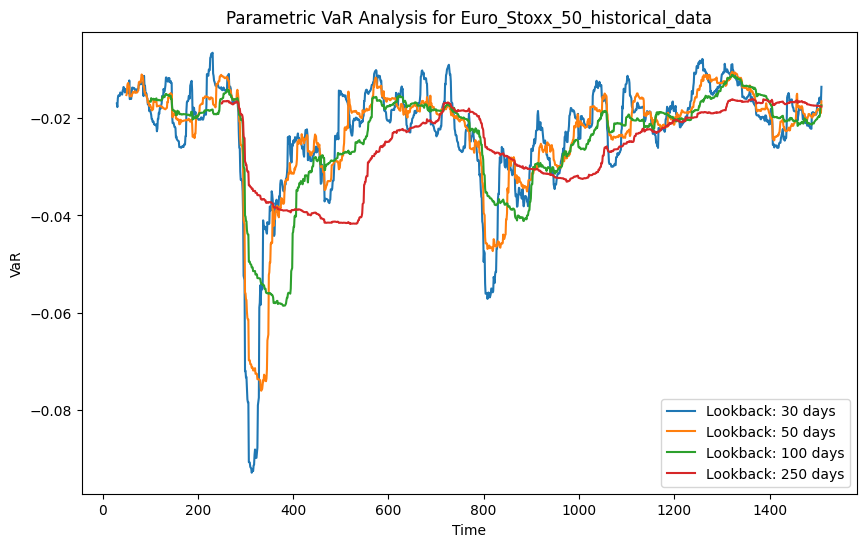

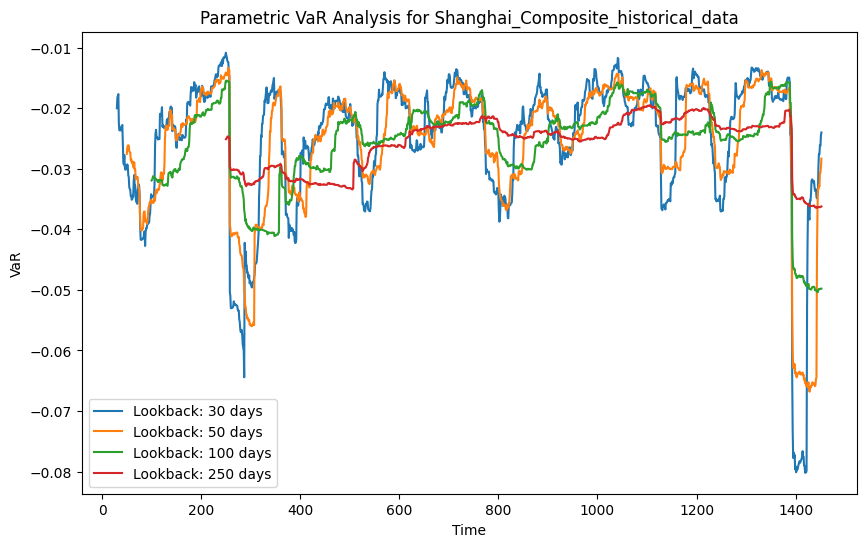

In [82]:
for symbol, period_results in var_results2.items():
    plt.figure(figsize=(10, 6))
    for period, series in period_results.items():
        plt.plot(series.index, series.values, label=f'Lookback: {period} days')
    plt.title(f'Parametric VaR Analysis for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('VaR')
    plt.legend()
    plt.show()

In [77]:
def gaussian_var(dataframes, lookback_periods, confidence_level=0.99):
    z_score = abs(np.percentile(np.random.standard_normal(100000), 100 * (1 - confidence_level)))
    var_results = {}

    for symbol, final_df in dataframes.items():
        data = final_df.toPandas()

        data['return'] = data['Close'].pct_change()
        data.dropna(subset=['return'], inplace=True)

        var_results[symbol] = {}

        for period in lookback_periods:
            rolling_mean = data['return'].rolling(period).mean()
            rolling_std = data['return'].rolling(period).std()

            var_series = rolling_mean - z_score * rolling_std

            var_series.dropna(inplace=True)

            var_results[symbol][period] = var_series

    return var_results

In [79]:
lookback_periods = [30, 50, 100, 250]
confidence_level = 0.99

var_results3 = gaussian_var(dataframes, lookback_periods=lookback_periods, confidence_level=confidence_level)

for symbol, period_results in var_results3.items():
    for period, series in period_results.items():
        print(f"Symbol: {symbol}, Lookback: {period} days")
        print(series.head())


Symbol: S&P_500_historical_data, Lookback: 30 days
30   -0.014231
31   -0.014231
32   -0.013270
33   -0.011252
34   -0.011041
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 50 days
50   -0.014000
51   -0.014005
52   -0.013463
53   -0.012359
54   -0.012398
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 100 days
100   -0.013847
101   -0.014426
102   -0.014257
103   -0.013681
104   -0.013657
Name: return, dtype: float64
Symbol: S&P_500_historical_data, Lookback: 250 days
250   -0.014935
251   -0.015026
252   -0.014960
253   -0.014725
254   -0.014699
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 30 days
30   -0.014078
31   -0.014098
32   -0.012234
33   -0.010136
34   -0.010151
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 50 days
50   -0.014588
51   -0.014603
52   -0.013583
53   -0.012418
54   -0.012839
Name: return, dtype: float64
Symbol: Dow_Jones_historical_data, Lookback: 100 days


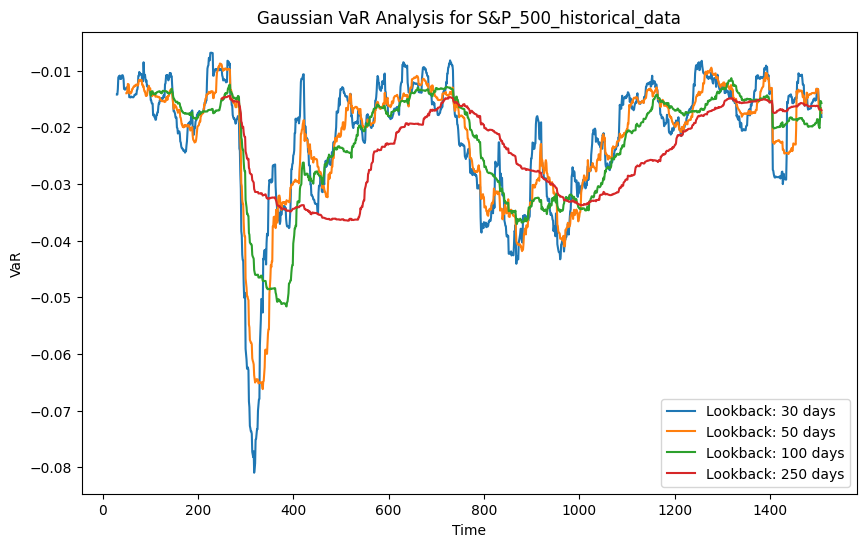

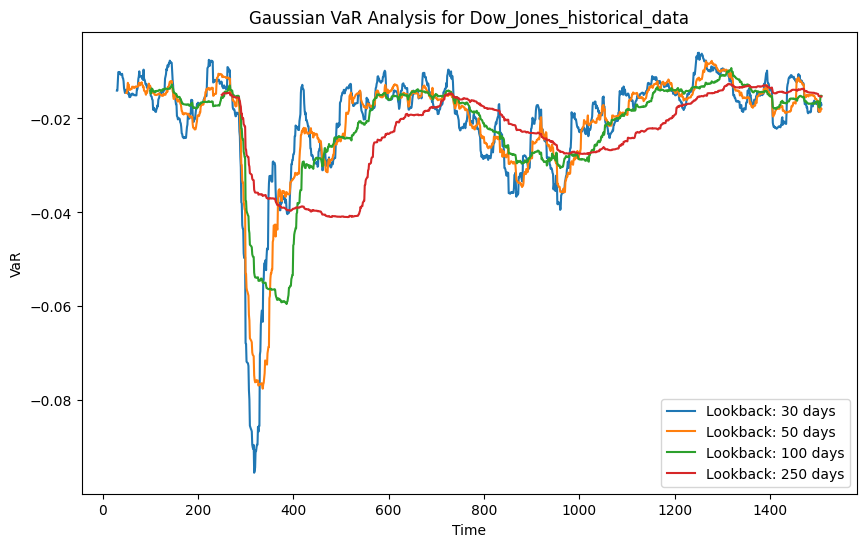

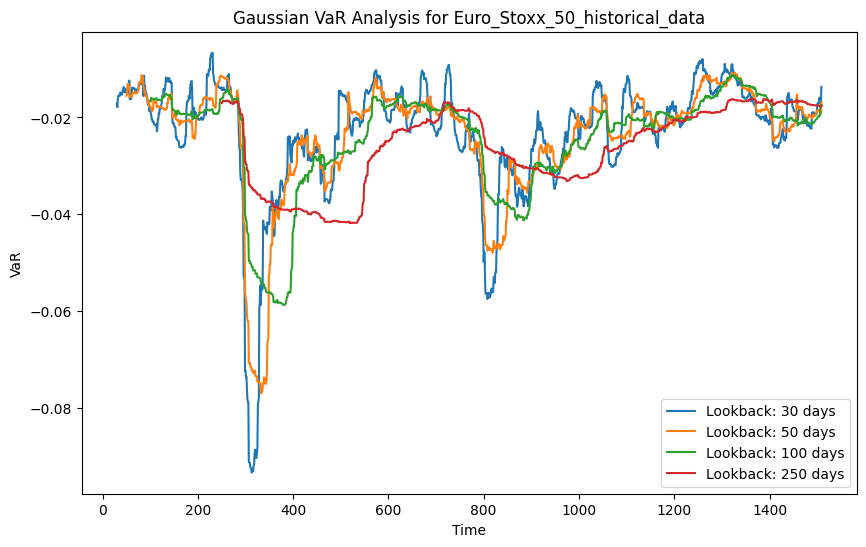

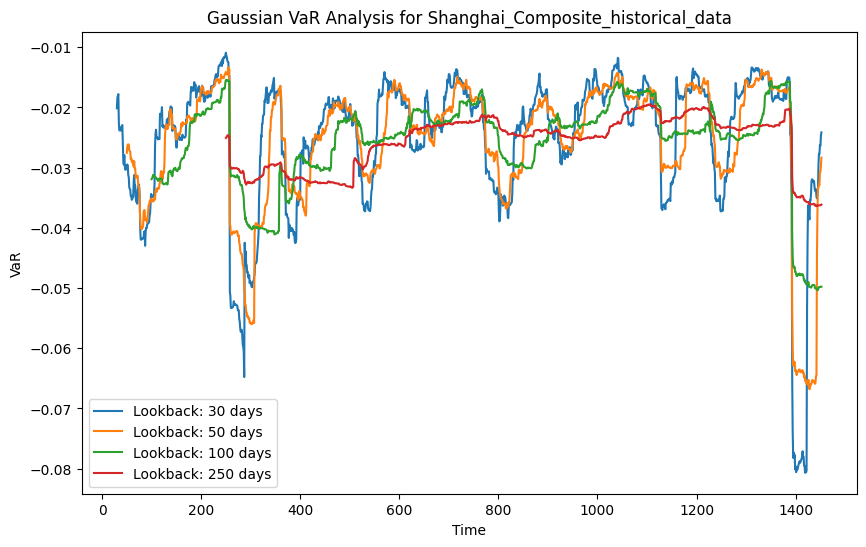

In [83]:
for symbol, period_results in var_results3.items():
    plt.figure(figsize=(10, 6))
    for period, series in period_results.items():
        plt.plot(series.index, series.values, label=f'Lookback: {period} days')
    plt.title(f'Gaussian VaR Analysis for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('VaR')
    plt.legend()
    plt.show()